# Parlay simulation




In [11]:
# Jupyter Notebook: Simulation of Parlay Smart Contract LP 

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import numpy as np
import numba as nb
from numba import jit, float64, int64, boolean
from numba.experimental import jitclass
from numba.typed import List, Dict
import numba.types as types
from numba.types import ListType, DictType, unicode_type

# Set display options
%matplotlib inline


## Introduction

This is a simulation of our smart contract LP. It reads the odds of whitelisted prediction market and lets users place parlays from 2-10 legs. The payout is inline with the odds of all events occurring with a set margin. This simulation will show the feasibility and profitability of this system.

**Rules:**

    The balance of the contract may never be negative, wagers must be refused if it is not possible to payout all the winners
    Bets cannot be 'cashed out' early and only close with a win or loss
    All prediction markets resolve as either YES / NO. Invalid markets and multiple options are not considered
    All events are settled at the same time
    The parlays are placed each betting cycle, after the cycle winners are paid out and new markets whitelisted and the cycle starts again

**Contract Parameters:**

    The contract starts with $10000 of liquidity
    The reserves required for taking a single bet must not exceed 10% of the available liquidity
    Hedging wagers will be placed to reduce the amount of reserves required
    Reserves may be shared between bets in which the winner cannot possibly win in both scenarios
    A flat margin will be taken on all payouts to ensure a profit. Starts at 5% but subject to change
    There are a set of 10 unique events to make parlays on

**Bettors:**

    Bets are made in random sizes
    Bets are made with random number of legs 
    Prediction market odds are not static, but normally distributed around 50%, parlay odds are correlated to calculated odds and number of legs


## Constants & Classes



In [12]:
# Constants (these are automatically recognized by Numba)
STARTING_LIQUIDITY = 10000.0
MAX_EXPOSURE_PER_BET = 0.10
FLAT_MARGIN = 0.05
NUM_EVENTS = 10
BETTING_CYCLES = 100
ODDS_LIMIT = 1000.0
NUM_BETTORS_PER_CYCLE = 10000
MIN_BET_SIZE = 1.0
MAX_BET_SIZE = 100.0
MIN_LEGS = 2
MAX_LEGS = 10
HEDGE_THRESHOLD = 0.01
MAX_HEDGE_PER_EVENT = 0.10

# Class Specifications
bet_spec = [
    ('bet_size', float64),
    ('num_legs', int64),
    ('selected_events', int64[:]),
    ('selected_outcomes', int64[:]),
    ('selected_odds', float64[:]),
    ('parlay_odds', float64),
    ('potential_payout', float64)
]

hedge_spec = [
    ('event', int64),
    ('side', int64),
    ('size', float64),
    ('odds', float64)
]

# Core Classes
@jitclass(bet_spec)
class Bet:
    def __init__(self, bet_size, num_legs):
        self.bet_size = bet_size
        self.num_legs = num_legs
        self.selected_events = np.zeros(num_legs, dtype=np.int64)
        self.selected_outcomes = np.zeros(num_legs, dtype=np.int64)
        self.selected_odds = np.zeros(num_legs, dtype=np.float64)
        self.parlay_odds = 0.0
        self.potential_payout = 0.0

@jitclass(hedge_spec)
class Hedge:
    def __init__(self, event, side, size, odds):
        self.event = event
        self.side = side
        self.size = size
        self.odds = odds

# Get types for list creation
bet_type = Bet.class_type.instance_type
hedge_type = Hedge.class_type.instance_type

## Utility Functions

These helper functions are used for data management.

In [13]:
# Utility Functions
@jit(nopython=True)
def clip_value(value, min_val, max_val):
    """Numba-compatible value clipping"""
    return min(max(value, min_val), max_val)

@jit(nopython=True)
def get_market_odds():
    """Generate market odds for an event"""
    base_probability = clip_value(np.random.normal(0.5, 0.15), 0.1, 0.9)
    return 1/base_probability, 1/(1-base_probability)

@jit(nopython=True)
def create_empty_bet_list():
    return List.empty_list(bet_type)

@jit(nopython=True)
def create_empty_hedge_list():
    return List.empty_list(hedge_type)

## Bet management functions


In [14]:
# Bet Creation and Management
@jit(nopython=True)
def create_bet(bet_size, num_legs):
    return Bet(bet_size, num_legs)

@jit(nopython=True)
def create_hedge(event, side, size, odds):
    return Hedge(event, side, size, odds)

@jit(nopython=True)
def simulate_single_bet():
    """Create a single bet with random parameters"""
    bet_size = np.random.uniform(MIN_BET_SIZE, MAX_BET_SIZE)
    num_legs = np.random.randint(MIN_LEGS, MAX_LEGS + 1)
    bet = create_bet(bet_size, num_legs)
    
    # Generate selected events
    available_events = np.arange(NUM_EVENTS)
    for i in range(num_legs):
        idx = np.random.randint(0, NUM_EVENTS - i)
        bet.selected_events[i] = available_events[idx]
        available_events[idx] = available_events[NUM_EVENTS - i - 1]
    
    # Generate outcomes and odds
    parlay_odds = 1.0
    for i in range(num_legs):
        bet.selected_outcomes[i] = np.random.randint(0, 2)
        probability = clip_value(np.random.normal(0.5, 0.15), 0.1, 0.9)
        decimal_odds = 1.0 / probability
        bet.selected_odds[i] = decimal_odds
        parlay_odds *= decimal_odds
    
    parlay_odds_with_margin = parlay_odds / (1.0 + FLAT_MARGIN)
    if parlay_odds_with_margin > ODDS_LIMIT:
        return None
        
    bet.parlay_odds = parlay_odds_with_margin
    bet.potential_payout = bet_size * parlay_odds_with_margin
    return bet

# Risk Management
@jit(nopython=True)
def check_shared_reserves(accepted_bets, new_bet, current_liquidity):
    """Check if new bet can be accepted given current reserves"""
    if len(accepted_bets) == 0:
        return new_bet.potential_payout <= current_liquidity
        
    total_exposure = new_bet.potential_payout
    for bet in accepted_bets:
        total_exposure += bet.potential_payout
        if total_exposure > current_liquidity:
            return False
            
    return True

@jit(nopython=True)
def calculate_net_exposure(accepted_bets, current_hedges):
    """Calculate net exposure per event"""
    exposure = np.zeros(NUM_EVENTS)
    
    for bet in accepted_bets:
        for i in range(bet.num_legs):
            event = bet.selected_events[i]
            outcome = bet.selected_outcomes[i]
            other_prob = 1.0
            for j in range(bet.num_legs):
                if j != i:
                    other_prob *= 1/bet.selected_odds[j]
            
            if outcome == 1:
                exposure[event] += bet.potential_payout * other_prob
            else:
                exposure[event] -= bet.potential_payout * other_prob
    
    for hedge in current_hedges:
        if hedge.side == 1:
            exposure[hedge.event] -= hedge.size * hedge.odds
        else:
            exposure[hedge.event] += hedge.size * hedge.odds
            
    return exposure

@jit(nopython=True)
def update_hedges(accepted_bets, current_hedges, current_liquidity):
    """Update hedge positions based on current exposure"""
    exposure = calculate_net_exposure(accepted_bets, current_hedges)
    new_hedges = create_empty_hedge_list()
    remaining_liquidity = current_liquidity
    
    for event in range(NUM_EVENTS):
        if abs(exposure[event]) > current_liquidity * HEDGE_THRESHOLD:
            hedge_size = min(abs(exposure[event]) * 0.8, current_liquidity * MAX_HEDGE_PER_EVENT)
            
            if hedge_size > 0 and remaining_liquidity >= hedge_size:
                yes_odds, no_odds = get_market_odds()
                side = 0 if exposure[event] > 0 else 1
                odds = no_odds if exposure[event] > 0 else yes_odds
                
                new_hedges.append(create_hedge(event, side, hedge_size, odds))
                remaining_liquidity -= hedge_size
                
    return new_hedges, remaining_liquidity

@jit(nopython=True)
def settle_hedges(hedges, outcomes):
    """Calculate returns from hedge positions"""
    total_return = 0.0
    for hedge in hedges:
        if (hedge.side == 1 and outcomes[hedge.event] == 1) or \
           (hedge.side == 0 and outcomes[hedge.event] == 0):
            total_return += hedge.size * hedge.odds
    return total_return



## Simulation Functions

In [15]:
# Main Simulation Functions
@jit(nopython=True)
def run_simulation(run_number, enable_hedging):
    """Run a single simulation"""
    liquidity = STARTING_LIQUIDITY
    liquidity_over_time = np.zeros(BETTING_CYCLES + 1)
    profit_over_time = np.zeros(BETTING_CYCLES)
    hedge_returns = np.zeros(BETTING_CYCLES)
    liquidity_over_time[0] = liquidity
    
    for cycle in range(BETTING_CYCLES):
        accepted_bets = create_empty_bet_list()
        current_hedges = create_empty_hedge_list()
        total_wagers = 0.0
        available_liquidity = liquidity
        
        # Accept bets
        for _ in range(NUM_BETTORS_PER_CYCLE):
            bet = simulate_single_bet()
            if bet is not None:
                max_reserve = available_liquidity * MAX_EXPOSURE_PER_BET
                if bet.potential_payout - bet.bet_size <= max_reserve:
                    if check_shared_reserves(accepted_bets, bet, available_liquidity):
                        accepted_bets.append(bet)
                        total_wagers += bet.bet_size
                        
                        if enable_hedging:
                            current_hedges, available_liquidity = update_hedges(
                                accepted_bets, current_hedges, available_liquidity
                            )
        
        if len(accepted_bets) == 0:
            liquidity_over_time[cycle + 1] = liquidity
            continue
            
        # Simulate outcomes and settle
        outcomes = np.random.randint(0, 2, size=NUM_EVENTS)
        total_payouts = 0.0
        
        for bet in accepted_bets:
            bet_wins = True
            for i in range(bet.num_legs):
                if outcomes[bet.selected_events[i]] != bet.selected_outcomes[i]:
                    bet_wins = False
                    break
            if bet_wins:
                total_payouts += bet.potential_payout
        
        hedge_return = 0.0
        if enable_hedging and len(current_hedges) > 0:
            hedge_return = settle_hedges(current_hedges, outcomes)
            
        profit = total_wagers - total_payouts + hedge_return
        liquidity += profit
        
        liquidity_over_time[cycle + 1] = liquidity
        profit_over_time[cycle] = profit
        hedge_returns[cycle] = hedge_return
        
    return liquidity_over_time, profit_over_time, hedge_returns

def run_multiple_simulations(num_runs, enable_hedging=False):
    """Run multiple simulations and collect results"""
    results = []
    for run in range(num_runs):
        liquidity_over_time, profit_over_time, hedge_returns = run_simulation(run + 1, enable_hedging)
        results.append({
            'run_number': run + 1,
            'hedging_enabled': enable_hedging,
            'liquidity_over_time': liquidity_over_time,
            'profit_over_time': profit_over_time,
            'hedge_returns_over_time': hedge_returns,
            'ending_liquidity': liquidity_over_time[-1]
        })
    return results

## Plotting Functions

In [16]:
def aggregate_simulation_metrics(results):
    """Aggregate metrics across simulation runs"""
    metrics = {
        'avg_ending_liquidity': np.mean([r['ending_liquidity'] for r in results]),
        'std_ending_liquidity': np.std([r['ending_liquidity'] for r in results]),
        'min_ending_liquidity': min(r['ending_liquidity'] for r in results),
        'max_ending_liquidity': max(r['ending_liquidity'] for r in results),
        'avg_profit': np.mean([sum(r['profit_over_time']) for r in results]),
        'std_profit': np.std([sum(r['profit_over_time']) for r in results]),
    }
    return metrics


def plot_simulation_comparisons(hedged_results, unhedged_results, save_path=None):
    """Plot comprehensive comparison between hedged and unhedged simulations"""
    
    # Convert lists to numpy arrays for easier manipulation
    hedged_liquidity = np.array([r['liquidity_over_time'] for r in hedged_results])
    unhedged_liquidity = np.array([r['liquidity_over_time'] for r in unhedged_results])
    hedged_profits = np.array([r['profit_over_time'] for r in hedged_results])
    unhedged_profits = np.array([r['profit_over_time'] for r in unhedged_results])
    
    # 1. Liquidity Over Time
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    
    cycles = range(len(hedged_results[0]['liquidity_over_time']))
    
    for liq in unhedged_liquidity:
        plt.plot(cycles, liq, 'r-', alpha=0.2)
    for liq in hedged_liquidity:
        plt.plot(cycles, liq, 'b-', alpha=0.2)
        
    plt.plot(cycles, np.mean(unhedged_liquidity, axis=0), 'r-', 
             label='Unhedged Mean', linewidth=2)
    plt.plot(cycles, np.mean(hedged_liquidity, axis=0), 'g-', 
             label='Hedged Mean', linewidth=2)
    
    plt.title('Liquidity Over Time')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Liquidity ($)')
    plt.legend()
    plt.grid(True)
    
    # 2. Profit Distribution
    plt.subplot(2, 2, 2)
    
    hedged_total_profits = np.sum(hedged_profits, axis=1)
    unhedged_total_profits = np.sum(unhedged_profits, axis=1)
    
    plt.hist(unhedged_total_profits, bins=20, alpha=0.5, color='r', 
             label='Unhedged')
    plt.hist(hedged_total_profits, bins=20, alpha=0.5, color='b', 
             label='Hedged')
    
    plt.title('Total Profit Distribution')
    plt.xlabel('Total Profit ($)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # 3. Cumulative Profit Over Time
    plt.subplot(2, 2, 3)
    
    hedged_cum_profits = np.cumsum(hedged_profits, axis=1)
    unhedged_cum_profits = np.cumsum(unhedged_profits, axis=1)
    
    cycles = range(1, BETTING_CYCLES + 1)
    
    plt.plot(cycles, np.mean(unhedged_cum_profits, axis=0), 'r-', 
             label='Unhedged Mean')
    plt.plot(cycles, np.mean(hedged_cum_profits, axis=0), 'g-', 
             label='Hedged Mean')
    
    plt.fill_between(cycles, 
                     np.percentile(unhedged_cum_profits, 25, axis=0),
                     np.percentile(unhedged_cum_profits, 75, axis=0),
                     color='r', alpha=0.2)
    plt.fill_between(cycles,
                     np.percentile(hedged_cum_profits, 25, axis=0),
                     np.percentile(hedged_cum_profits, 75, axis=0),
                     color='b', alpha=0.2)
    
    plt.title('Cumulative Profit Over Time')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Cumulative Profit ($)')
    plt.legend()
    plt.grid(True)
    
    # 4. Risk Metrics
    plt.subplot(2, 2, 4)
    
    hedged_metrics = aggregate_simulation_metrics(hedged_results)
    unhedged_metrics = aggregate_simulation_metrics(unhedged_results)
    
    metrics_data = {
        'Metric': ['Ending Liquidity', 'Total Profit', 'Std Dev'],
        'Hedged': [hedged_metrics['avg_ending_liquidity'],
                  hedged_metrics['avg_profit'],
                  hedged_metrics['std_ending_liquidity']],
        'Unhedged': [unhedged_metrics['avg_ending_liquidity'],
                    unhedged_metrics['avg_profit'],
                    unhedged_metrics['std_ending_liquidity']]
    }
    
    df = pd.DataFrame(metrics_data)
    df.plot(x='Metric', kind='bar', rot=0)
    plt.title('Risk Metrics Comparison')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

## Running the Simulation

In [17]:
# Run the simulation
print("Starting Parlay Smart Contract LP Simulation...")
print(f"Configuration:")
print(f"Starting Liquidity: ${STARTING_LIQUIDITY:,.2f}")
print(f"Number of Events: {NUM_EVENTS}")
print(f"Betting Cycles: {BETTING_CYCLES}")
print(f"Bettors per Cycle: {NUM_BETTORS_PER_CYCLE}")

num_simulation_runs = 10000
print(f"\nRunning {num_simulation_runs} simulations for each strategy...")

hedged_results = run_multiple_simulations(num_simulation_runs, enable_hedging=True)
unhedged_results = run_multiple_simulations(num_simulation_runs, enable_hedging=False)



Starting Parlay Smart Contract LP Simulation...
Configuration:
Starting Liquidity: $10,000.00
Number of Events: 10
Betting Cycles: 100
Bettors per Cycle: 10000

Running 10000 simulations for each strategy...


## Much more detailed Plotting

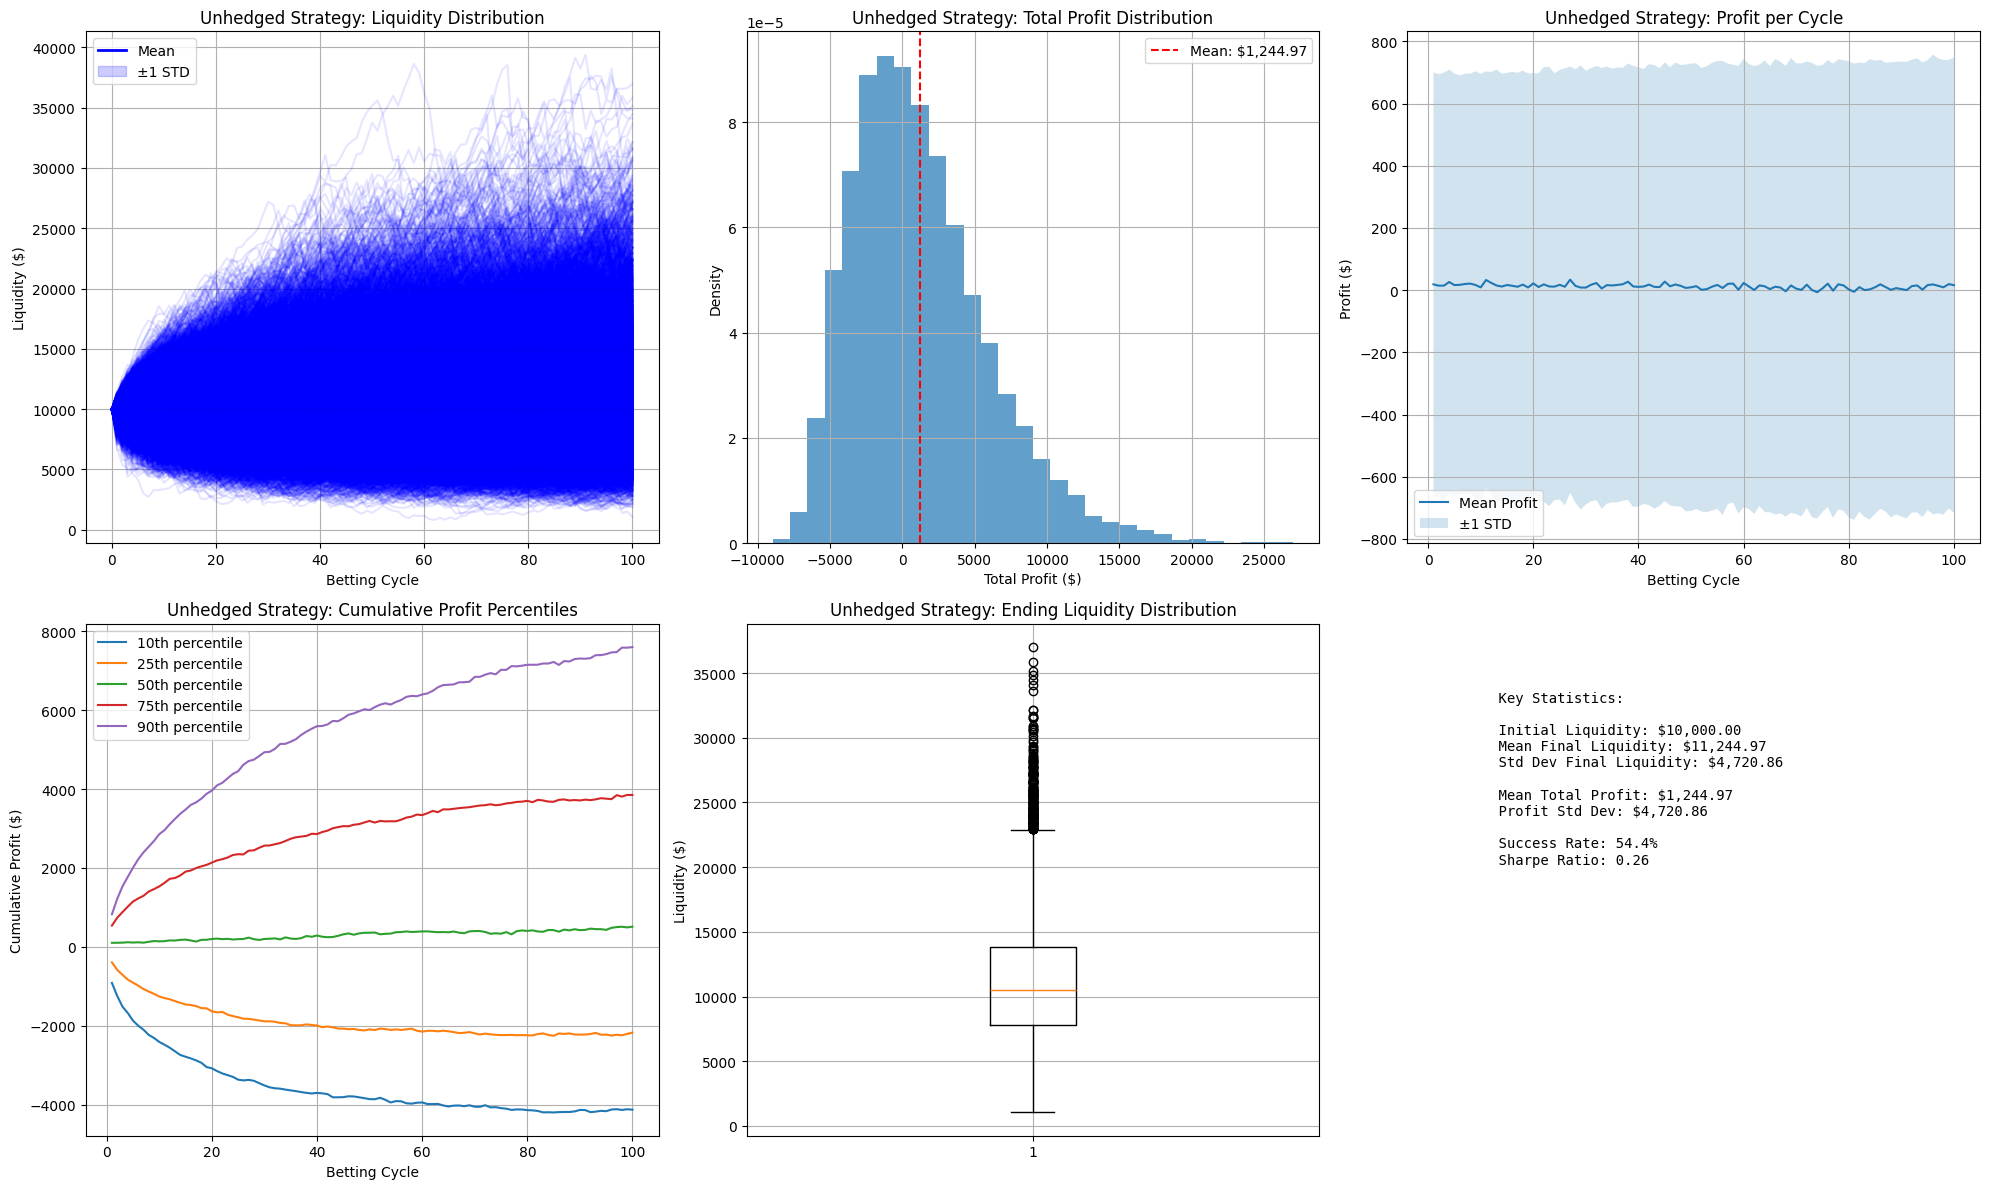

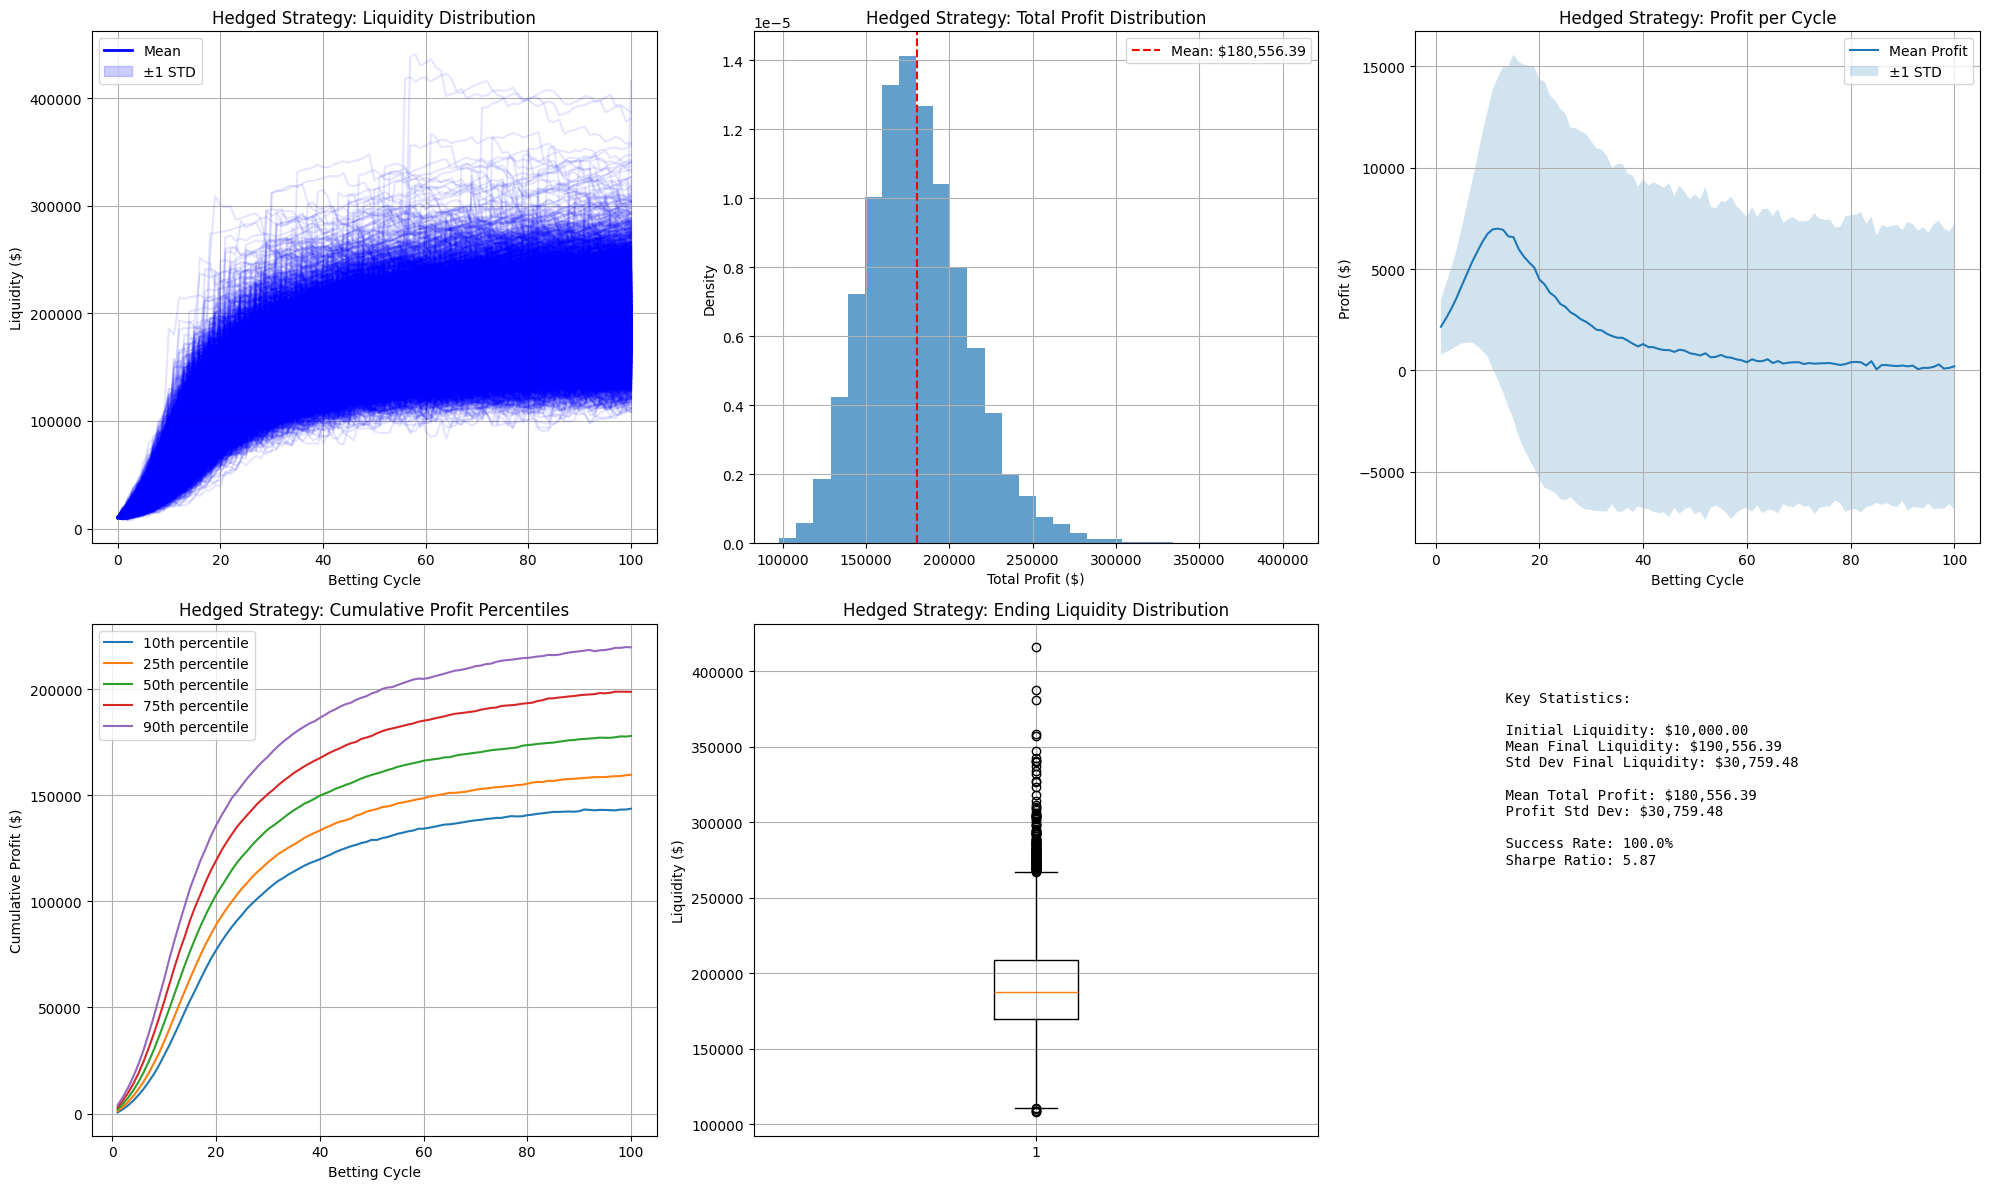

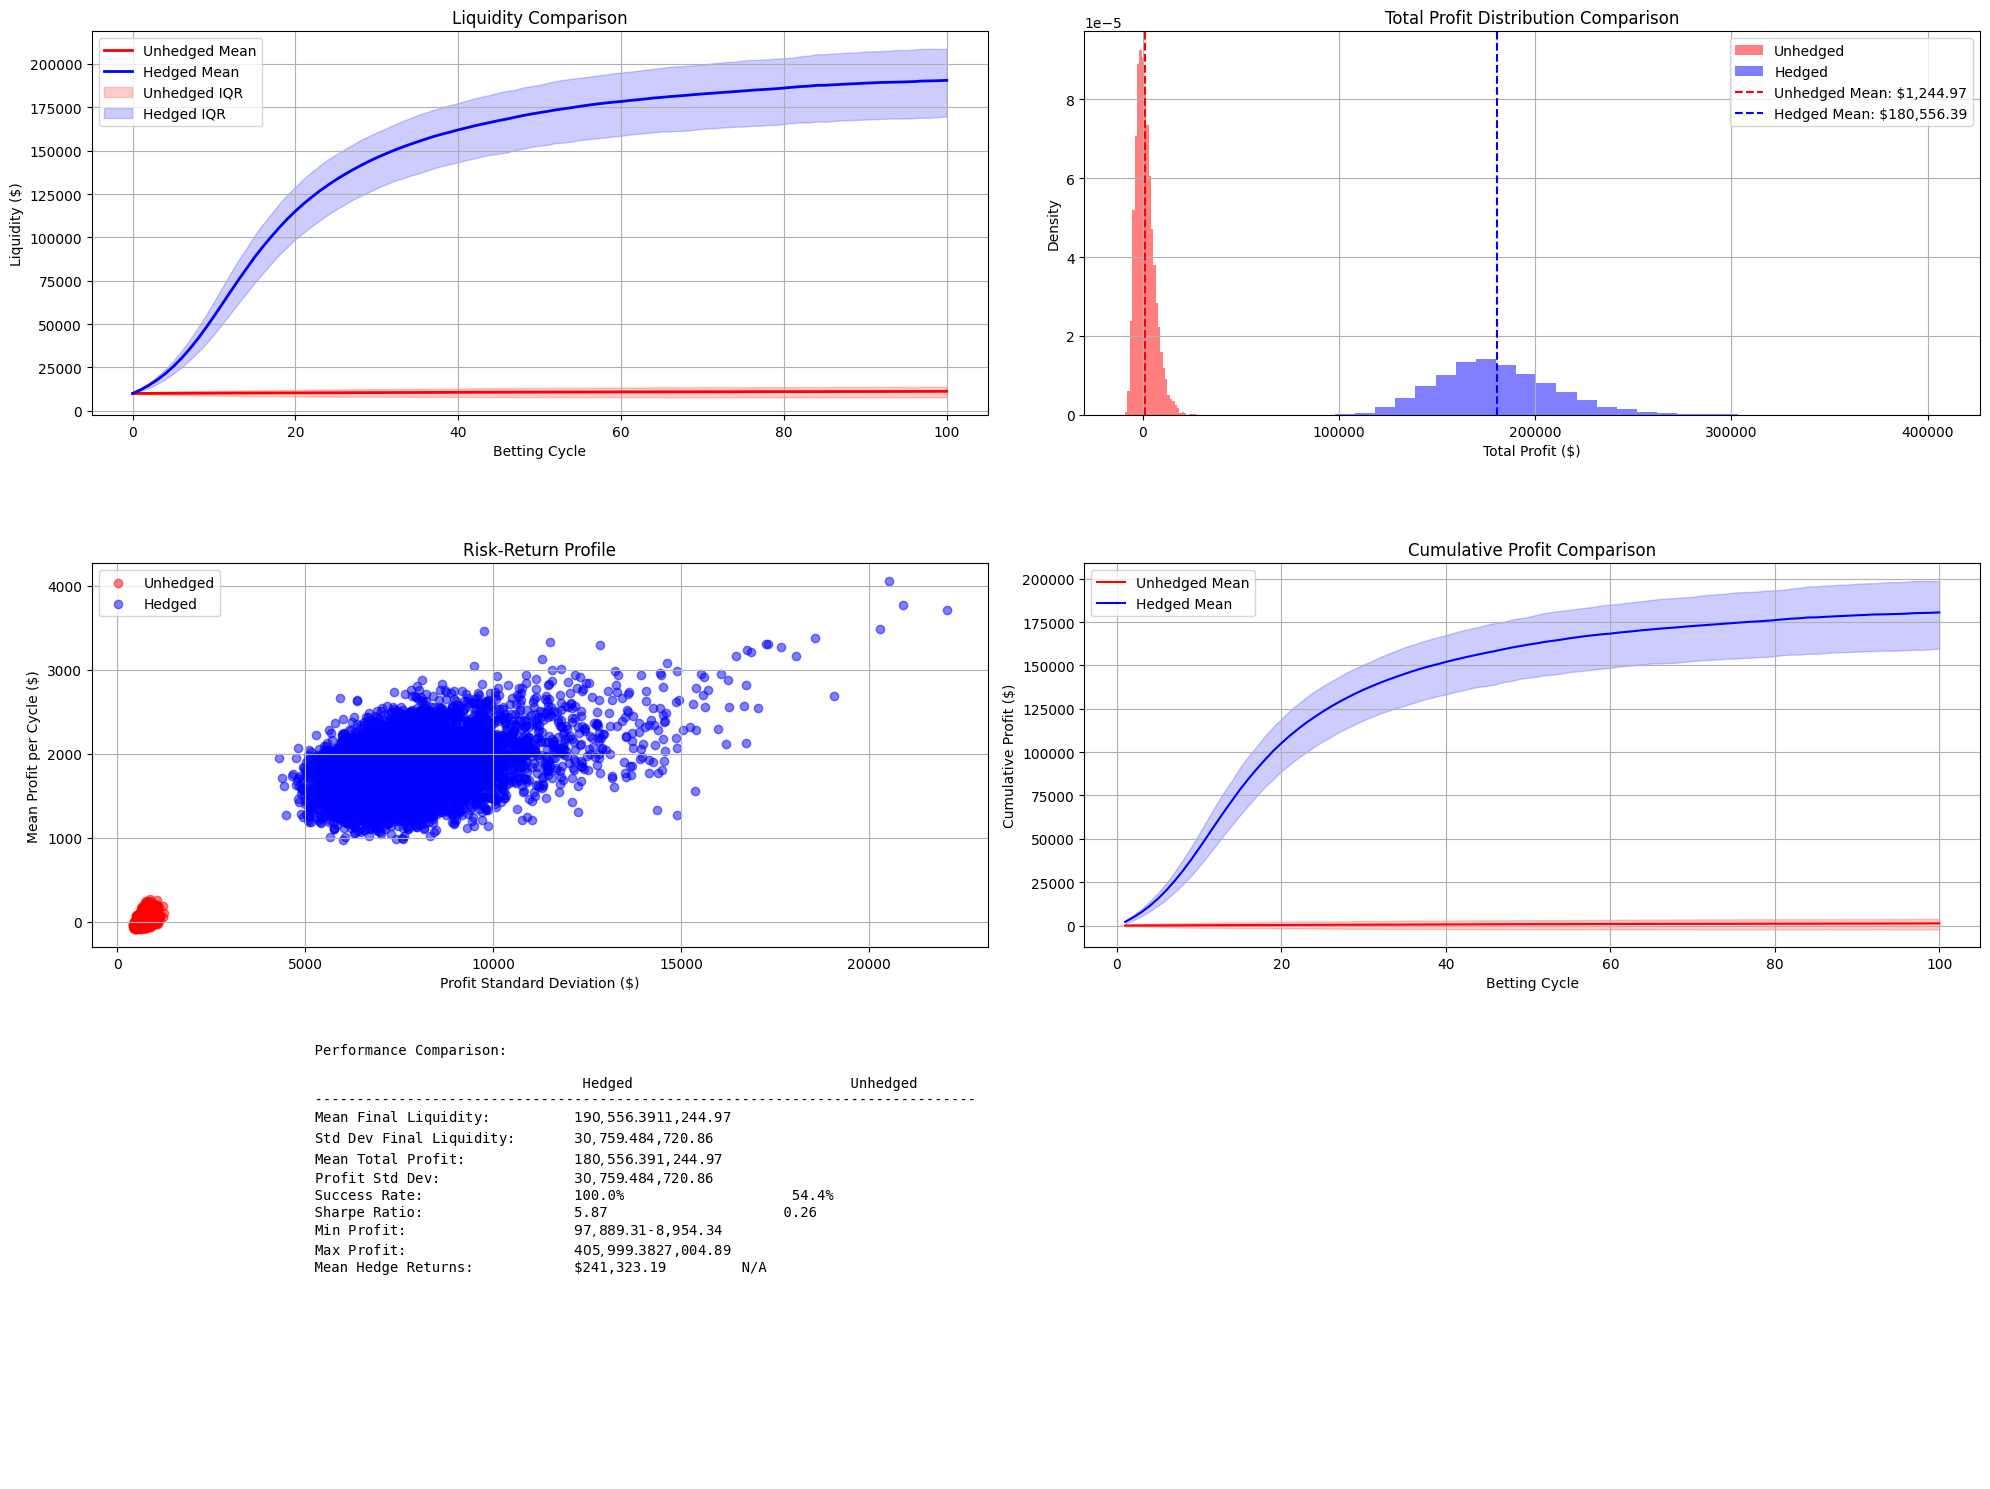

In [18]:
def plot_detailed_simulation(results, strategy_name, save_path=None):
    """Create detailed plots for a single simulation strategy"""
    plt.figure(figsize=(20, 12))
    
    # Convert results to numpy arrays
    liquidity_data = np.array([r['liquidity_over_time'] for r in results])
    profit_data = np.array([r['profit_over_time'] for r in results])
    hedge_returns = np.array([r['hedge_returns_over_time'] for r in results])
    cycles = range(len(results[0]['liquidity_over_time']))
    betting_cycles = range(1, BETTING_CYCLES + 1)
    
    # 1. Liquidity Distribution Over Time
    plt.subplot(2, 3, 1)
    for liq in liquidity_data:
        plt.plot(cycles, liq, 'b-', alpha=0.1)
    
    mean_liquidity = np.mean(liquidity_data, axis=0)
    std_liquidity = np.std(liquidity_data, axis=0)
    
    plt.plot(cycles, mean_liquidity, 'b-', label='Mean', linewidth=2)
    plt.fill_between(cycles, 
                     mean_liquidity - std_liquidity,
                     mean_liquidity + std_liquidity,
                     color='b', alpha=0.2, label='±1 STD')
    
    plt.title(f'{strategy_name}: Liquidity Distribution')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Liquidity ($)')
    plt.grid(True)
    plt.legend()
    
    # 2. Profit Distribution
    plt.subplot(2, 3, 2)
    total_profits = np.sum(profit_data, axis=1)
    
    plt.hist(total_profits, bins=30, density=True, alpha=0.7)
    plt.axvline(np.mean(total_profits), color='r', linestyle='dashed', 
                label=f'Mean: ${np.mean(total_profits):,.2f}')
    
    plt.title(f'{strategy_name}: Total Profit Distribution')
    plt.xlabel('Total Profit ($)')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    
    # 3. Profit Over Time
    plt.subplot(2, 3, 3)
    mean_profits = np.mean(profit_data, axis=0)
    std_profits = np.std(profit_data, axis=0)
    
    plt.plot(betting_cycles, mean_profits, label='Mean Profit')
    plt.fill_between(betting_cycles,
                     mean_profits - std_profits,
                     mean_profits + std_profits,
                     alpha=0.2, label='±1 STD')
    
    plt.title(f'{strategy_name}: Profit per Cycle')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Profit ($)')
    plt.grid(True)
    plt.legend()
    
    # 4. Cumulative Profit Distribution
    plt.subplot(2, 3, 4)
    cum_profits = np.cumsum(profit_data, axis=1)
    
    percentiles = [10, 25, 50, 75, 90]
    for p in percentiles:
        plt.plot(betting_cycles, np.percentile(cum_profits, p, axis=0),
                label=f'{p}th percentile')
    
    plt.title(f'{strategy_name}: Cumulative Profit Percentiles')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Cumulative Profit ($)')
    plt.grid(True)
    plt.legend()
    
    # 5. Risk Metrics
    plt.subplot(2, 3, 5)
    ending_liquidity = liquidity_data[:, -1]
    metrics = {
        'Min': np.min(ending_liquidity),
        'Q1': np.percentile(ending_liquidity, 25),
        'Median': np.median(ending_liquidity),
        'Q3': np.percentile(ending_liquidity, 75),
        'Max': np.max(ending_liquidity)
    }
    
    plt.boxplot(ending_liquidity)
    plt.title(f'{strategy_name}: Ending Liquidity Distribution')
    plt.ylabel('Liquidity ($)')
    plt.grid(True)
    
    # 6. Additional Statistics Table
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    stats_text = f"""
    Key Statistics:
    
    Initial Liquidity: ${STARTING_LIQUIDITY:,.2f}
    Mean Final Liquidity: ${np.mean(ending_liquidity):,.2f}
    Std Dev Final Liquidity: ${np.std(ending_liquidity):,.2f}
    
    Mean Total Profit: ${np.mean(total_profits):,.2f}
    Profit Std Dev: ${np.std(total_profits):,.2f}
    
    Success Rate: {(np.sum(total_profits > 0) / len(total_profits)) * 100:.1f}%
    Sharpe Ratio: {np.mean(total_profits) / np.std(total_profits):.2f}
    """
    
    plt.text(0.1, 0.5, stats_text, fontsize=10, family='monospace')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_strategy_comparison(hedged_results, unhedged_results, save_path=None):
    """Create comprehensive comparison plots between hedged and unhedged strategies"""
    plt.figure(figsize=(20, 15))
    
    # Convert results to numpy arrays
    hedged_liquidity = np.array([r['liquidity_over_time'] for r in hedged_results])
    unhedged_liquidity = np.array([r['liquidity_over_time'] for r in unhedged_results])
    hedged_profits = np.array([r['profit_over_time'] for r in hedged_results])
    unhedged_profits = np.array([r['profit_over_time'] for r in unhedged_results])
    hedged_hedge_returns = np.array([r['hedge_returns_over_time'] for r in hedged_results])
    
    cycles = range(len(hedged_results[0]['liquidity_over_time']))
    betting_cycles = range(1, BETTING_CYCLES + 1)
    
    # 1. Liquidity Comparison
    plt.subplot(3, 2, 1)
    
    plt.plot(cycles, np.mean(unhedged_liquidity, axis=0), 'r-', 
             label='Unhedged Mean', linewidth=2)
    plt.plot(cycles, np.mean(hedged_liquidity, axis=0), 'b-', 
             label='Hedged Mean', linewidth=2)
    
    plt.fill_between(cycles,
                     np.percentile(unhedged_liquidity, 25, axis=0),
                     np.percentile(unhedged_liquidity, 75, axis=0),
                     color='r', alpha=0.2, label='Unhedged IQR')
    plt.fill_between(cycles,
                     np.percentile(hedged_liquidity, 25, axis=0),
                     np.percentile(hedged_liquidity, 75, axis=0),
                     color='b', alpha=0.2, label='Hedged IQR')
    
    plt.title('Liquidity Comparison')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Liquidity ($)')
    plt.grid(True)
    plt.legend()
    
    # 2. Profit Distribution Comparison
    plt.subplot(3, 2, 2)
    
    hedged_total_profits = np.sum(hedged_profits, axis=1)
    unhedged_total_profits = np.sum(unhedged_profits, axis=1)
    
    plt.hist(unhedged_total_profits, bins=30, alpha=0.5, color='r', 
             density=True, label='Unhedged')
    plt.hist(hedged_total_profits, bins=30, alpha=0.5, color='b', 
             density=True, label='Hedged')
    
    plt.axvline(np.mean(unhedged_total_profits), color='r', linestyle='--',
                label=f'Unhedged Mean: ${np.mean(unhedged_total_profits):,.2f}')
    plt.axvline(np.mean(hedged_total_profits), color='b', linestyle='--',
                label=f'Hedged Mean: ${np.mean(hedged_total_profits):,.2f}')
    
    plt.title('Total Profit Distribution Comparison')
    plt.xlabel('Total Profit ($)')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    
    # 3. Risk-Return Scatter
    plt.subplot(3, 2, 3)
    
    plt.scatter(np.std(unhedged_profits, axis=1), 
               np.mean(unhedged_profits, axis=1),
               alpha=0.5, color='r', label='Unhedged')
    plt.scatter(np.std(hedged_profits, axis=1),
               np.mean(hedged_profits, axis=1),
               alpha=0.5, color='b', label='Hedged')
    
    plt.title('Risk-Return Profile')
    plt.xlabel('Profit Standard Deviation ($)')
    plt.ylabel('Mean Profit per Cycle ($)')
    plt.grid(True)
    plt.legend()
    
    # 4. Cumulative Profit Comparison
    plt.subplot(3, 2, 4)
    
    hedged_cum_profits = np.cumsum(hedged_profits, axis=1)
    unhedged_cum_profits = np.cumsum(unhedged_profits, axis=1)
    
    plt.plot(betting_cycles, np.mean(unhedged_cum_profits, axis=0), 'r-',
             label='Unhedged Mean')
    plt.plot(betting_cycles, np.mean(hedged_cum_profits, axis=0), 'b-',
             label='Hedged Mean')
    
    plt.fill_between(betting_cycles,
                     np.percentile(unhedged_cum_profits, 25, axis=0),
                     np.percentile(unhedged_cum_profits, 75, axis=0),
                     color='r', alpha=0.2)
    plt.fill_between(betting_cycles,
                     np.percentile(hedged_cum_profits, 25, axis=0),
                     np.percentile(hedged_cum_profits, 75, axis=0),
                     color='b', alpha=0.2)
    
    plt.title('Cumulative Profit Comparison')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Cumulative Profit ($)')
    plt.grid(True)
    plt.legend()
    
    # 5. Performance Metrics Table
    plt.subplot(3, 2, (5, 6))
    plt.axis('off')
    
    metrics_text = f"""
    Performance Comparison:
    
                                    Hedged                          Unhedged
    -------------------------------------------------------------------------------
    Mean Final Liquidity:          ${np.mean(hedged_liquidity[:, -1]):,.2f}        ${np.mean(unhedged_liquidity[:, -1]):,.2f}
    Std Dev Final Liquidity:       ${np.std(hedged_liquidity[:, -1]):,.2f}         ${np.std(unhedged_liquidity[:, -1]):,.2f}
    Mean Total Profit:             ${np.mean(hedged_total_profits):,.2f}         ${np.mean(unhedged_total_profits):,.2f}
    Profit Std Dev:                ${np.std(hedged_total_profits):,.2f}          ${np.std(unhedged_total_profits):,.2f}
    Success Rate:                  {(np.sum(hedged_total_profits > 0) / len(hedged_total_profits)) * 100:.1f}%                    {(np.sum(unhedged_total_profits > 0) / len(unhedged_total_profits)) * 100:.1f}%
    Sharpe Ratio:                  {np.mean(hedged_total_profits) / np.std(hedged_total_profits):.2f}                     {np.mean(unhedged_total_profits) / np.std(unhedged_total_profits):.2f}
    Min Profit:                    ${np.min(hedged_total_profits):,.2f}         ${np.min(unhedged_total_profits):,.2f}
    Max Profit:                    ${np.max(hedged_total_profits):,.2f}         ${np.max(unhedged_total_profits):,.2f}
    Mean Hedge Returns:            ${np.mean(np.sum(hedged_hedge_returns, axis=1)):,.2f}         N/A
    """
    
    plt.text(0.1, 0.5, metrics_text, fontsize=10, family='monospace')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage:
plot_detailed_simulation(unhedged_results, "Unhedged Strategy", "unhedged_analysis.png")
plot_detailed_simulation(hedged_results, "Hedged Strategy", "hedged_analysis.png")
plot_strategy_comparison(hedged_results, unhedged_results, "strategy_comparison.png")


Generating visualization and analysis...


/home/dov/Documents/okay-bet/research/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


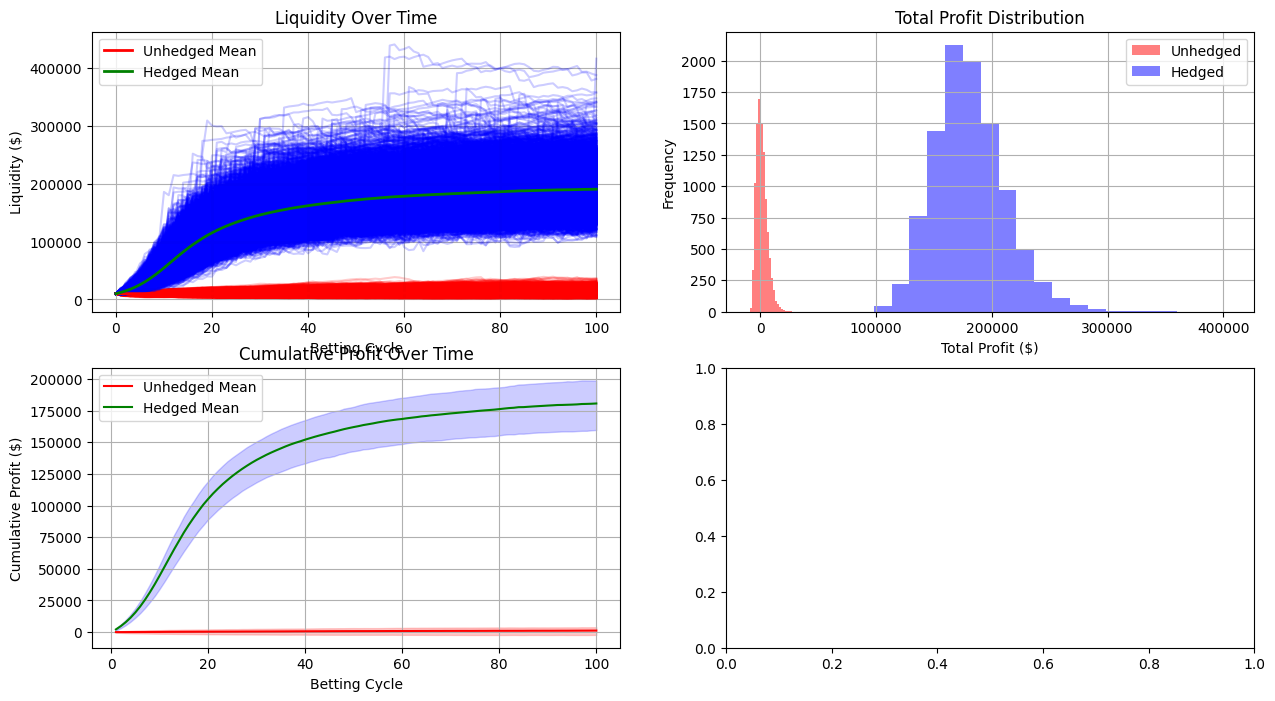

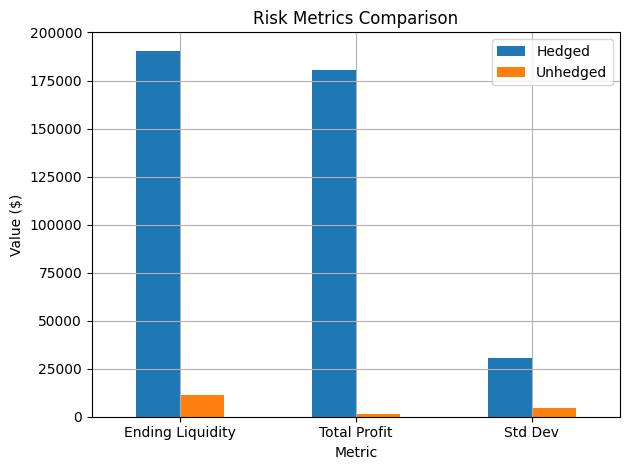

NameError: name 'print_simulation_summary' is not defined

In [19]:
print("\nGenerating visualization and analysis...")
plot_simulation_comparisons(hedged_results, unhedged_results)
print_simulation_summary(hedged_results, unhedged_results)

In [ ]:
@jit(nopython=True)
def run_simulation_with_tracking(run_number, enable_hedging, hedge_threshold):
    """Run simulation with detailed hedge transaction tracking"""
    liquidity = STARTING_LIQUIDITY
    liquidity_over_time = np.zeros(BETTING_CYCLES + 1)
    profit_over_time = np.zeros(BETTING_CYCLES)
    hedge_returns = np.zeros(BETTING_CYCLES)
    hedge_buys = np.zeros(BETTING_CYCLES)  # Track number of buy hedges per cycle
    hedge_sells = np.zeros(BETTING_CYCLES)  # Track number of sell hedges per cycle
    hedge_volume = np.zeros(BETTING_CYCLES)  # Track total hedge volume per cycle
    liquidity_over_time[0] = liquidity
    
    for cycle in range(BETTING_CYCLES):
        accepted_bets = create_empty_bet_list()
        current_hedges = create_empty_hedge_list()
        total_wagers = 0.0
        available_liquidity = liquidity
        cycle_hedge_volume = 0.0
        
        # Accept bets
        for _ in range(NUM_BETTORS_PER_CYCLE):
            bet = simulate_single_bet()
            if bet is not None:
                max_reserve = available_liquidity * MAX_EXPOSURE_PER_BET
                if bet.potential_payout - bet.bet_size <= max_reserve:
                    if check_shared_reserves(accepted_bets, bet, available_liquidity):
                        accepted_bets.append(bet)
                        total_wagers += bet.bet_size
                        
                        if enable_hedging:
                            prev_hedge_count = len(current_hedges)
                            exposure = calculate_net_exposure(accepted_bets, current_hedges)
                            
                            for event in range(NUM_EVENTS):
                                if abs(exposure[event]) > available_liquidity * hedge_threshold:
                                    hedge_size = min(abs(exposure[event]) * 0.8, 
                                                   available_liquidity * MAX_HEDGE_PER_EVENT)
                                    yes_odds, no_odds = get_market_odds()
                                    side = 0 if exposure[event] > 0 else 1
                                    odds = no_odds if exposure[event] > 0 else yes_odds
                                    
                                    if hedge_size > 0 and available_liquidity >= hedge_size:
                                        new_hedge = create_hedge(event, side, hedge_size, odds)
                                        current_hedges.append(new_hedge)
                                        available_liquidity -= hedge_size
                                        cycle_hedge_volume += hedge_size
                                        
                                        # Track buy/sell hedges
                                        if side == 1:
                                            hedge_buys[cycle] += 1
                                        else:
                                            hedge_sells[cycle] += 1
        
        hedge_volume[cycle] = cycle_hedge_volume
        
        # Simulate outcomes and settle
        outcomes = np.random.randint(0, 2, size=NUM_EVENTS)
        total_payouts = 0.0
        
        for bet in accepted_bets:
            bet_wins = True
            for i in range(bet.num_legs):
                if outcomes[bet.selected_events[i]] != bet.selected_outcomes[i]:
                    bet_wins = False
                    break
            if bet_wins:
                total_payouts += bet.potential_payout
        
        hedge_return = 0.0
        if enable_hedging and len(current_hedges) > 0:
            hedge_return = settle_hedges(current_hedges, outcomes)
            
        profit = total_wagers - total_payouts + hedge_return
        liquidity += profit
        
        liquidity_over_time[cycle + 1] = liquidity
        profit_over_time[cycle] = profit
        hedge_returns[cycle] = hedge_return
        
    return (liquidity_over_time, profit_over_time, hedge_returns, 
            hedge_buys, hedge_sells, hedge_volume)

def run_multiple_simulations_with_tracking(num_runs, enable_hedging=False, hedge_threshold=0.05):
    """Run multiple simulations and collect results including hedge transactions"""
    results = []
    for run in range(num_runs):
        (liquidity_over_time, profit_over_time, hedge_returns,
         hedge_buys, hedge_sells, hedge_volume) = run_simulation_with_tracking(run + 1, 
                                                                             enable_hedging,
                                                                             hedge_threshold)
        results.append({
            'run_number': run + 1,
            'hedging_enabled': enable_hedging,
            'hedge_threshold': hedge_threshold,
            'liquidity_over_time': liquidity_over_time,
            'profit_over_time': profit_over_time,
            'hedge_returns_over_time': hedge_returns,
            'hedge_buys': hedge_buys,
            'hedge_sells': hedge_sells,
            'hedge_volume': hedge_volume,
            'ending_liquidity': liquidity_over_time[-1]
        })
    return results

def plot_hedge_transaction_comparison(results_1pct, results_5pct):
    """Compare hedging activity between 1% and 5% threshold strategies"""
    plt.figure(figsize=(20, 12))
    
    # Extract hedge transaction data
    buys_1pct = np.array([r['hedge_buys'] for r in results_1pct])
    sells_1pct = np.array([r['hedge_sells'] for r in results_1pct])
    volume_1pct = np.array([r['hedge_volume'] for r in results_1pct])
    
    buys_5pct = np.array([r['hedge_buys'] for r in results_5pct])
    sells_5pct = np.array([r['hedge_sells'] for r in results_5pct])
    volume_5pct = np.array([r['hedge_volume'] for r in results_5pct])
    
    cycles = range(1, BETTING_CYCLES + 1)
    
    # 1. Number of Hedge Transactions
    plt.subplot(2, 2, 1)
    plt.plot(cycles, np.mean(buys_1pct + sells_1pct, axis=0), 'b-', 
             label='1% Threshold')
    plt.plot(cycles, np.mean(buys_5pct + sells_5pct, axis=0), 'r-', 
             label='5% Threshold')
    
    plt.title('Average Number of Hedge Transactions per Cycle')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Number of Transactions')
    plt.grid(True)
    plt.legend()
    
    # 2. Buy vs Sell Distribution
    plt.subplot(2, 2, 2)
    labels = ['1% Buys', '1% Sells', '5% Buys', '5% Sells']
    values = [np.mean(np.sum(buys_1pct, axis=1)), 
              np.mean(np.sum(sells_1pct, axis=1)),
              np.mean(np.sum(buys_5pct, axis=1)), 
              np.mean(np.sum(sells_5pct, axis=1))]
    
    plt.bar(labels, values)
    plt.title('Average Total Buy vs Sell Hedges')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # 3. Hedge Volume Over Time
    plt.subplot(2, 2, 3)
    plt.plot(cycles, np.mean(volume_1pct, axis=0), 'b-', label='1% Threshold')
    plt.plot(cycles, np.mean(volume_5pct, axis=0), 'r-', label='5% Threshold')
    
    plt.title('Average Hedge Volume per Cycle')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Volume ($)')
    plt.grid(True)
    plt.legend()
    
    # 4. Transaction Statistics
    plt.subplot(2, 2, 4)
    plt.axis('off')
    
    stats_text = f"""
    Hedge Transaction Statistics:
    
    1% Threshold:
    Average Daily Transactions: {np.mean(np.mean(buys_1pct + sells_1pct, axis=0)):.1f}
    Total Transactions per Run: {np.mean(np.sum(buys_1pct + sells_1pct, axis=1)):.1f}
    Average Daily Volume: ${np.mean(np.mean(volume_1pct, axis=0)):,.2f}
    Total Volume per Run: ${np.mean(np.sum(volume_1pct, axis=1)):,.2f}
    Buy/Sell Ratio: {np.mean(np.sum(buys_1pct, axis=1))/np.mean(np.sum(sells_1pct, axis=1)):.2f}
    
    5% Threshold:
    Average Daily Transactions: {np.mean(np.mean(buys_5pct + sells_5pct, axis=0)):.1f}
    Total Transactions per Run: {np.mean(np.sum(buys_5pct + sells_5pct, axis=1)):.1f}
    Average Daily Volume: ${np.mean(np.mean(volume_5pct, axis=0)):,.2f}
    Total Volume per Run: ${np.mean(np.sum(volume_5pct, axis=1)):,.2f}
    Buy/Sell Ratio: {np.mean(np.sum(buys_5pct, axis=1))/np.mean(np.sum(sells_5pct, axis=1)):.2f}
    
    Transaction Increase Factor: {np.mean(np.sum(buys_1pct + sells_1pct, axis=1))/np.mean(np.sum(buys_5pct + sells_5pct, axis=1)):.2f}x
    Volume Increase Factor: {np.mean(np.sum(volume_1pct, axis=1))/np.mean(np.sum(volume_5pct, axis=1)):.2f}x
    """
    
    plt.text(0.1, 0.5, stats_text, fontsize=10, family='monospace')
    
    plt.tight_layout()
    plt.show()

# Run simulations with different thresholds
print("Running simulations...")
results_1pct = run_multiple_simulations_with_tracking(100, True, 0.01)
results_5pct = run_multiple_simulations_with_tracking(100, True, 0.05)

# Plot comparison
plot_hedge_transaction_comparison(results_1pct, results_5pct)

# Vestigel code

In [ ]:
# Contract parameters
starting_liquidity = 10000.0  # Starting liquidity in dollars
liquidity = starting_liquidity  # Current liquidity
max_exposure_per_bet = 0.10  # 10% of available liquidity
flat_margin = 0.05  # 5% margin
num_events = 10  # Number of unique events
events = [f'Event_{i+1}' for i in range(num_events)]  # List of event names
betting_cycles = 5  # Number of betting cycles to simulate
odds_limit = 1000.0  # Maximum allowed odds (1000 to 1)


1.2 Define Bet

In [ ]:
# Bettor parameters
num_bettors_per_cycle = 1000  # Number of bettors per betting cycle
min_bet_size = 1.0  # Minimum bet size
max_bet_size = 100.0  # Maximum bet size
min_legs = 2  # Minimum number of legs in a parlay
max_legs = 10  # Maximum number of legs in a parlay


1.3 Initialize Data Structures

In [ ]:
# Data structures to store simulation results
liquidity_over_time = [liquidity]
profit_over_time = []


2. Simulating Betting Cycles

We will simulate a specified number of betting cycles. In each cycle:

    Simulate Bettor Behavior: Bettors place bets with random sizes and random legs. Event odds are generated dynamically for each bettor.
    Enforce Contract Rules: Bets exceeding liquidity constraints are refused.
    Calculate Reserves and Hedging: Determine the reserves required and apply hedging strategies, accounting for partial offsets due to different odds.
    Settle Bets: Simulate the outcomes and settle bets.
    Update Liquidity: Adjust the contract's liquidity based on payouts and profits.

2.1 Function to Simulate a Single Bet with Dynamic Odds

In [ ]:
def simulate_single_bet():
    """
    Simulate a single bettor placing a parlay bet with dynamic odds.
    Returns the bet dictionary or None if the bet is rejected.
    """
    bet_size = np.random.uniform(min_bet_size, max_bet_size)
    num_legs = np.random.randint(min_legs, max_legs + 1)
    selected_events = np.random.choice(events, size=num_legs, replace=False)
    selected_outcomes = np.random.choice([0, 1], size=num_legs)  # 0: NO, 1: YES

    # Generate odds for the selected events at the time of bet placement
    selected_odds = []
    for event in selected_events:
        probability = np.clip(np.random.normal(0.5, 0.15), 0.1, 0.9)  # Probabilities between 0.1 and 0.9
        decimal_odds = 1 / probability  # Convert probability to decimal odds
        selected_odds.append(decimal_odds)

    # Calculate total odds for the parlay
    parlay_odds = np.prod(selected_odds)

    # Apply the margin
    parlay_odds_with_margin = parlay_odds / (1 + flat_margin)

    # Check if parlay odds exceed the odds limit
    if parlay_odds_with_margin > odds_limit:
        return None  # Bet is rejected due to high odds

    bet = {
        'bet_size': bet_size,
        'num_legs': num_legs,
        'selected_events': selected_events,
        'selected_outcomes': selected_outcomes,
        'selected_odds': selected_odds,
        'parlay_odds': parlay_odds_with_margin,
        'potential_payout': bet_size * parlay_odds_with_margin
    }
    return bet


Explanation:

    Dynamic Odds: For each bettor, we generate odds for their selected events at the time of bet placement. This simulates changing odds in the prediction markets.
    Event Odds Generation: The odds are generated based on probabilities normally distributed around 50%, ensuring they fall between 10% and 90%.

## 2.2 Function to Determine if a Bet Can Be Accepted 

To consider shared reserves due to mutually exclusive bets, we need to calculate the maximum possible payout across all possible outcomes with the existing bets and the new bet. If adding the new bet doesn't increase the maximum possible payout beyond the liquidity, we can accept it.

Due to computational limitations, we will:

    Generate all possible outcome combinations of the events involved in the accepted bets and the new bet.
    Calculate the total potential payout for each outcome.
    Determine the maximum total payout.
    Compare it to the liquidity.

Note: Since the number of possible outcomes increases exponentially with the number of events, we need to limit the number of events considered.

To make it computationally feasible, we will:

    Limit the number of events considered to a manageable size, e.g., events involved in the current bets (usually less than or equal to 20).
    Use an efficient data structure to store and calculate payouts.

In [ ]:
# Precompute all possible outcomes for a given number of events
from functools import lru_cache

@lru_cache(maxsize=None)
def get_all_possible_outcomes(num_events):
    return list(itertools.product([0, 1], repeat=num_events))


In [ ]:
def can_accept_bet_with_shared_reserves(accepted_bets, new_bet, current_liquidity):
    """Optimized shared reserves check with early exits"""
    
    # Early exit 1: If no existing bets, just check new bet's payout
    if not accepted_bets:
        return new_bet['potential_payout'] <= current_liquidity
        
    # Early exit 2: Check if just the new bet exceeds liquidity
    if new_bet['potential_payout'] > current_liquidity:
        return False
    
    # Early exit 3: Quick sum check - if total of all potential payouts is less than liquidity
    total_potential = sum(bet['potential_payout'] for bet in accepted_bets) + new_bet['potential_payout']
    if total_potential <= current_liquidity:
        return True
        
    # Combine events from accepted bets and the new bet
    events_in_bets = set()
    for bet in accepted_bets + [new_bet]:
        events_in_bets.update(bet['selected_events'])
    events_in_bets = list(events_in_bets)
    
    # Early exit 4: Too many events to compute combinations
    if len(events_in_bets) > 15:
        return False
    
    # Create lookup for faster event checking
    event_indices = {event: idx for idx, event in enumerate(events_in_bets)}
    
    # Get cached outcomes
    all_possible_outcomes = get_all_possible_outcomes(len(events_in_bets))
    
    # Check each outcome until we find one that exceeds liquidity
    for outcome in all_possible_outcomes:
        total_payout = 0.0
        
        # Check each bet against this outcome
        for bet in accepted_bets + [new_bet]:
            # Quick check if bet wins
            bet_wins = True
            for event, desired_outcome in zip(bet['selected_events'], bet['selected_outcomes']):
                if outcome[event_indices[event]] != desired_outcome:
                    bet_wins = False
                    break
                    
            if bet_wins:
                total_payout += bet['potential_payout']
                # Early exit 5: Stop checking this outcome if already over liquidity
                if total_payout > current_liquidity:
                    return False
    
    return True

## 2.3 We hedge at the portfolio level to 

In [ ]:
def calculate_net_exposure(accepted_bets, current_hedges):
    """
    Calculate net exposure per event considering both bets and existing hedges.
    """
    event_exposure = defaultdict(lambda: {'yes': 0, 'no': 0, 'net': 0})
    
    # Calculate exposure from parlays
    for bet in accepted_bets:
        for i, (event, outcome) in enumerate(zip(bet['selected_events'], bet['selected_outcomes'])):
            # Calculate probability of other events in parlay
            other_prob = 1.0
            for j, odds in enumerate(bet['selected_odds']):
                if j != i:
                    other_prob *= 1/odds
            
            exposure = bet['potential_payout'] * other_prob
            if outcome == 1:
                event_exposure[event]['yes'] += exposure
            else:
                event_exposure[event]['no'] += exposure
    
    # Subtract existing hedge exposure
    for hedge in current_hedges:
        if hedge['side'] == 'yes':
            event_exposure[hedge['event']]['yes'] -= hedge['size'] * hedge['odds']
        else:
            event_exposure[hedge['event']]['no'] -= hedge['size'] * hedge['odds']
    
    # Calculate net exposure
    for event in event_exposure:
        event_exposure[event]['net'] = event_exposure[event]['yes'] - event_exposure[event]['no']
    
    return dict(event_exposure)

In [ ]:
def get_current_market_odds(event, side):
    """
    Simulate getting current market odds for an event.
    In real implementation, this would query the prediction market.
    """
    base_probability = np.clip(np.random.normal(0.5, 0.15), 0.1, 0.9)
    
    # Return appropriate odds based on side
    if side == 'yes':
        return 1/base_probability
    else:
        return 1/(1-base_probability)

In [ ]:
def try_place_hedge(event, side, size, available_liquidity):
    """
    Attempt to place a hedge at current market odds.
    Returns (success, hedge_details, remaining_liquidity)
    """
    # Get current market odds at execution time
    execution_odds = get_current_market_odds(event, side)
    
    # Check if we can still afford this hedge at current odds
    cost = size
    potential_return = size * execution_odds
    
    if cost <= available_liquidity:
        hedge = {
            'event': event,
            'side': side,
            'size': size,
            'odds': execution_odds,  # Locked in odds at execution
        }
        return True, hedge, available_liquidity - cost
    
    return False, None, available_liquidity

In [ ]:
def update_hedge_positions(accepted_bets, current_hedges, current_liquidity):
    """
    Update hedge positions based on current net exposure.
    Returns new hedges and remaining liquidity.
    """
    exposure = calculate_net_exposure(accepted_bets, current_hedges)
    hedge_threshold = current_liquidity * 0.05  # Hedge when exposure > 15% of liquidity
    max_hedge_per_event = current_liquidity * 0.10  # Max 10% of liquidity per hedge
    new_hedges = current_hedges.copy()
    remaining_liquidity = current_liquidity
    
    for event, exp in exposure.items():
        if abs(exp['net']) > hedge_threshold:
            # Close opposing positions first
            new_hedges = [h for h in new_hedges if h['event'] != event]
            
            # Calculate new hedge size
            hedge_size = min(abs(exp['net']) * 0.8, max_hedge_per_event)
            
            if hedge_size > 0 and remaining_liquidity >= hedge_size:
                # Get current market price for hedge
                probability = np.clip(np.random.normal(0.5, 0.15), 0.1, 0.9)
                
                new_hedges.append({
                    'event': event,
                    'side': 'no' if exp['net'] > 0 else 'yes',
                    'size': hedge_size,
                    'odds': 1/probability if exp['net'] < 0 else 1/(1-probability)
                })
                remaining_liquidity -= hedge_size
    
    return new_hedges, remaining_liquidity

In [ ]:
def settle_hedges(hedges, event_outcomes):
    """
    Calculate returns from hedge positions based on event outcomes.
    """
    total_hedge_return = 0.0
    for hedge in hedges:
        if (hedge['side'] == 'yes' and event_outcomes[hedge['event']] == 1) or \
           (hedge['side'] == 'no' and event_outcomes[hedge['event']] == 0):
            total_hedge_return += hedge['size'] * hedge['odds']
    return total_hedge_return

Explanation:

    Net Exposure Calculation: We calculate the net exposure for each event by finding the difference in potential payouts between the two outcomes.
    Hedging Bets: The contract places hedging bets on the prediction market to offset the net exposure.
    Hedging Cost: The cost of hedging bets is accounted for, and we ensure it does not exceed liquidity.
    Reserves Required: After hedging, the net exposure (potential payouts to bettors) is reduced, and the reserves required are updated accordingly.

2.4 Functions to Simulate Event Outcomes and Settle Bets



In [ ]:
def simulate_event_outcomes(events):
    """
    Simulate the outcomes of all events (0: NO, 1: YES).
    """
    outcomes = np.random.choice([0, 1], size=len(events))
    return dict(zip(events, outcomes))
    

Explanation:

    Settling Bets: Calculate the total payout to bettors based on the outcomes.
    Settling Hedging Bets: Calculate the returns from hedging bets based on event outcomes.

Explanation:

    Dynamic Odds and Partial Hedging: The simulation now accounts for dynamic odds and partial hedging when calculating reserves.
    Adjusting Accepted Bets: If total reserves required exceed available liquidity, the simulation removes bets with the highest potential payout until the reserves required are within liquidity constraints.
    Liquidity Updates: The liquidity is updated after each cycle based on the actual bets accepted and the outcomes.

In [ ]:
def run_simulation(run_number, enable_hedging=False):
    """
    Run simulation with optional hedging.
    
    Parameters:
        run_number: int - The simulation run number
        enable_hedging: bool - Whether to enable dynamic hedging
    """
    liquidity = starting_liquidity
    liquidity_over_time = [liquidity]
    profit_over_time = []
    hedge_returns_over_time = []
    metrics = {
        'total_bets_accepted': 0,
        'total_wagers': 0,
        'total_hedge_cost': 0,
        'total_hedge_returns': 0,
        'max_drawdown': 0,
        'min_liquidity': liquidity,
    }
    
    for cycle in range(betting_cycles):
        accepted_bets = []
        current_hedges = []
        total_wagers = 0.0
        total_payout_to_bettors = 0.0
        available_liquidity = liquidity
        
        for _ in range(num_bettors_per_cycle):
            bet = simulate_single_bet()
            if bet is None:
                continue
                
            required_reserve = bet['potential_payout'] - bet['bet_size']
            max_allowed_reserve = available_liquidity * max_exposure_per_bet
            
            if required_reserve > max_allowed_reserve:
                continue
                
            if not can_accept_bet_with_shared_reserves(accepted_bets, bet, available_liquidity):
                continue
                
            accepted_bets.append(bet)
            total_wagers += bet['bet_size']
            metrics['total_bets_accepted'] += 1
            
            # Update hedges only if enabled
            if enable_hedging:
                current_hedges, available_liquidity = update_hedge_positions(
                    accepted_bets, current_hedges, available_liquidity
                )
        
        if not accepted_bets:
            profit_over_time.append(0.0)
            hedge_returns_over_time.append(0.0)
            liquidity_over_time.append(liquidity)
            continue
            
        metrics['total_wagers'] += total_wagers
        
        # Simulate outcomes and settle
        event_outcomes = simulate_event_outcomes(events)
        
        # Calculate bettor payouts
        for bet in accepted_bets:
            bet_wins = True
            for event, outcome in zip(bet['selected_events'], bet['selected_outcomes']):
                if event_outcomes[event] != outcome:
                    bet_wins = False
                    break
            if bet_wins:
                total_payout_to_bettors += bet['potential_payout']
        
        # Calculate hedge returns if enabled
        hedge_returns = 0.0
        if enable_hedging:
            hedge_returns = settle_hedges(current_hedges, event_outcomes)
            metrics['total_hedge_returns'] += hedge_returns
            if current_hedges:
                metrics['total_hedge_cost'] += sum(h['size'] for h in current_hedges)
        
        hedge_returns_over_time.append(hedge_returns)
        
        # Update liquidity and track metrics
        profit = total_wagers - total_payout_to_bettors + hedge_returns
        liquidity += profit
        
        metrics['min_liquidity'] = min(metrics['min_liquidity'], liquidity)
        current_drawdown = starting_liquidity - liquidity
        metrics['max_drawdown'] = max(metrics['max_drawdown'], current_drawdown)
        
        liquidity_over_time.append(liquidity)
        profit_over_time.append(profit)
        
        if run_number == 1:  # Only print for first run to reduce output
            print(f"Cycle {cycle + 1} Results:")
            print(f"Total Wagers: ${total_wagers:.2f}")
            print(f"Bets Accepted: {len(accepted_bets)}")
            if enable_hedging:
                print(f"Active Hedges: {len(current_hedges)}")
                print(f"Hedge Returns: ${hedge_returns:.2f}")
            print(f"Cycle Profit: ${profit:.2f}")
            print(f"Current Liquidity: ${liquidity:.2f}\n")
    
    return {
        'run_number': run_number,
        'hedging_enabled': enable_hedging,
        'liquidity_over_time': liquidity_over_time,
        'profit_over_time': profit_over_time,
        'hedge_returns_over_time': hedge_returns_over_time,
        'ending_liquidity': liquidity,
        'metrics': metrics
    }

4.3 Summary Statistics

In [ ]:
def plot_simulation_comparisons(hedged_results, unhedged_results):
    """Plot and save comprehensive comparison between hedged and unhedged simulations"""
    
    # 1. Liquidity Over Time
    plt.figure(figsize=(12, 6))
    for result in unhedged_results:
        plt.plot(result['liquidity_over_time'], alpha=0.3, color='red')
    for result in hedged_results:
        plt.plot(result['liquidity_over_time'], alpha=0.3, color='blue')
    avg_liquidity_unhedged = np.mean([result['liquidity_over_time'] for result in unhedged_results], axis=0)
    avg_liquidity_hedged = np.mean([result['liquidity_over_time'] for result in hedged_results], axis=0)
    plt.plot(avg_liquidity_unhedged, color='red', linewidth=2, label='Average Unhedged')
    plt.plot(avg_liquidity_hedged, color='blue', linewidth=2, label='Average Hedged')
    plt.title('Liquidity Over Time for Multiple Simulation Runs')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Liquidity ($)')
    plt.grid(True)
    plt.legend()
    plt.savefig('liquidity_over_time.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Cumulative Returns
    profits_matrix_unhedged = np.array([result['profit_over_time'] for result in unhedged_results])
    profits_matrix_hedged = np.array([result['profit_over_time'] for result in hedged_results])
    
    cumulative_profits_matrix_unhedged = np.cumsum(profits_matrix_unhedged, axis=1)
    cumulative_profits_matrix_hedged = np.cumsum(profits_matrix_hedged, axis=1)
    
    avg_cumulative_profits_unhedged = np.mean(cumulative_profits_matrix_unhedged, axis=0)
    avg_cumulative_profits_hedged = np.mean(cumulative_profits_matrix_hedged, axis=0)
    
    min_cumulative_profits_unhedged = np.min(cumulative_profits_matrix_unhedged, axis=0)
    max_cumulative_profits_unhedged = np.max(cumulative_profits_matrix_unhedged, axis=0)
    min_cumulative_profits_hedged = np.min(cumulative_profits_matrix_hedged, axis=0)
    max_cumulative_profits_hedged = np.max(cumulative_profits_matrix_hedged, axis=0)

    plt.figure(figsize=(12, 6))
    cycles = range(1, betting_cycles + 1)
    plt.plot(cycles, avg_cumulative_profits_unhedged, label='Average Unhedged Returns', color='red')
    plt.plot(cycles, avg_cumulative_profits_hedged, label='Average Hedged Returns', color='blue')
    plt.fill_between(cycles, min_cumulative_profits_unhedged, max_cumulative_profits_unhedged, 
                     color='red', alpha=0.2, label='Unhedged Range')
    plt.fill_between(cycles, min_cumulative_profits_hedged, max_cumulative_profits_hedged, 
                     color='blue', alpha=0.2, label='Hedged Range')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Cumulative Returns ($)')
    plt.legend()
    plt.grid(True)
    plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Standard Deviation Over Time
    liquidity_matrix_unhedged = np.array([result['liquidity_over_time'] for result in unhedged_results])
    liquidity_matrix_hedged = np.array([result['liquidity_over_time'] for result in hedged_results])
    
    liquidity_std_dev_unhedged = np.std(liquidity_matrix_unhedged, axis=0)
    liquidity_std_dev_hedged = np.std(liquidity_matrix_hedged, axis=0)

    plt.figure(figsize=(12, 6))
    cycles = range(betting_cycles + 1)
    plt.plot(cycles, liquidity_std_dev_unhedged, label='Unhedged Std Dev', color='red')
    plt.plot(cycles, liquidity_std_dev_hedged, label='Hedged Std Dev', color='blue')
    plt.title('Standard Deviation of Liquidity Over Time')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Standard Deviation ($)')
    plt.legend()
    plt.grid(True)
    plt.savefig('standard_deviation.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Mean and Median Liquidity
    mean_liquidity_unhedged = np.mean(liquidity_matrix_unhedged, axis=0)
    median_liquidity_unhedged = np.median(liquidity_matrix_unhedged, axis=0)
    mean_liquidity_hedged = np.mean(liquidity_matrix_hedged, axis=0)
    median_liquidity_hedged = np.median(liquidity_matrix_hedged, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, mean_liquidity_unhedged, label='Mean Unhedged', color='red')
    plt.plot(cycles, median_liquidity_unhedged, label='Median Unhedged', color='red', linestyle='--')
    plt.plot(cycles, mean_liquidity_hedged, label='Mean Hedged', color='blue')
    plt.plot(cycles, median_liquidity_hedged, label='Median Hedged', color='blue', linestyle='--')
    plt.title('Mean and Median Liquidity Comparison')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Liquidity ($)')
    plt.legend()
    plt.grid(True)
    plt.savefig('mean_median_liquidity.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Profit Distribution
    mean_profit_unhedged = np.mean(profits_matrix_unhedged, axis=0)
    std_profit_unhedged = np.std(profits_matrix_unhedged, axis=0)
    mean_profit_hedged = np.mean(profits_matrix_hedged, axis=0)
    std_profit_hedged = np.std(profits_matrix_hedged, axis=0)

    plt.figure(figsize=(12, 6))
    cycles = range(1, betting_cycles + 1)
    plt.plot(cycles, mean_profit_unhedged, label='Mean Unhedged Profit', color='red')
    plt.plot(cycles, mean_profit_hedged, label='Mean Hedged Profit', color='blue')
    plt.fill_between(cycles, 
                     mean_profit_unhedged - std_profit_unhedged,
                     mean_profit_unhedged + std_profit_unhedged,
                     color='red', alpha=0.2, label='Unhedged Std Dev')
    plt.fill_between(cycles,
                     mean_profit_hedged - std_profit_hedged,
                     mean_profit_hedged + std_profit_hedged,
                     color='blue', alpha=0.2, label='Hedged Std Dev')
    plt.title('Mean Profit per Cycle with Standard Deviation')
    plt.xlabel('Betting Cycle')
    plt.ylabel('Profit ($)')
    plt.legend()
    plt.grid(True)
    plt.savefig('profit_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Save summary statistics to text file
    with open('simulation_summary.txt', 'w') as f:
        f.write("Summary Statistics:\n\n")
        f.write("Unhedged Results:\n")
        f.write(f"Average Ending Liquidity: ${np.mean([r['ending_liquidity'] for r in unhedged_results]):.2f}\n")
        f.write(f"Final Std Dev: ${np.std([r['ending_liquidity'] for r in unhedged_results]):.2f}\n")
        f.write(f"Total Profit: ${np.mean([sum(r['profit_over_time']) for r in unhedged_results]):.2f}\n\n")
        
        f.write("Hedged Results:\n")
        f.write(f"Average Ending Liquidity: ${np.mean([r['ending_liquidity'] for r in hedged_results]):.2f}\n")
        f.write(f"Final Std Dev: ${np.std([r['ending_liquidity'] for r in hedged_results]):.2f}\n")
        f.write(f"Total Profit: ${np.mean([sum(r['profit_over_time']) for r in hedged_results]):.2f}\n")

In [ ]:
# Run simulations
num_simulation_runs = 5
hedged_results = []
unhedged_results = []

In [ ]:
# Run both types of simulations
for run in range(num_simulation_runs):
    print(f"Running simulation {run + 1}")
    hedged_result = run_simulation(run + 1, enable_hedging=True)
    unhedged_result = run_simulation(run + 1, enable_hedging=False)
    hedged_results.append(hedged_result)
    unhedged_results.append(unhedged_result)



In [ ]:
# Plot comparisons
plot_simulation_comparisons(hedged_results, unhedged_results)